In [1]:
import qmcpy as qp
import numpy as np
import math
import time
import matplotlib.pyplot as plt

print('okay')

okay


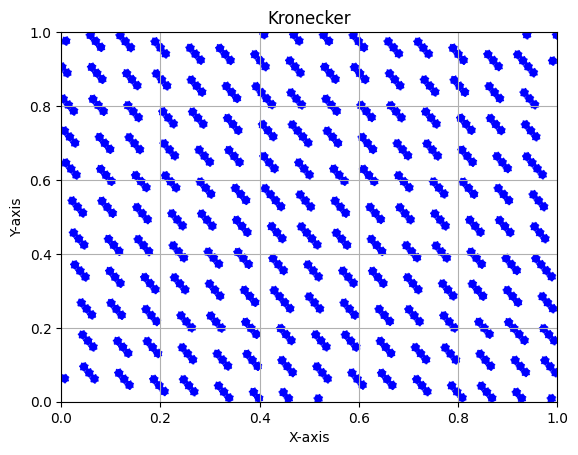

In [24]:
X = qp.kronecker(500, 2, alpha = np.array([np.sqrt(2), np.sqrt(3)])
x = X[:,0]
y = X[:,1]

# Create a line plot
plt.scatter(x, y, color='blue', linestyle='dotted')
plt.title('Kronecker')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()